In [103]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math

from basic_artificial_market import ArtificialMarket

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import math

class ArtificialMarket():
    def __init__(self, num_player=1000, fdmtl=10000.0, ganma=10000, sigma=0.06, P_sigma=30):
        self.num_player = num_player
        self.random_state = np.random.RandomState()
        self.weight = self.weight()
        self.fdmtl = fdmtl
        self.ganma = ganma
        self.sigma = sigma
        self.P_sigma = P_sigma
    
    def weight(self, w_1_max=1, w_2_max=10, w_3_max=1):
        num_player = self.num_player
        weight_1 = np.zeros(num_player)
        weight_2 = np.zeros(num_player)
        weight_3 = np.zeros(num_player)
        random_state = self.random_state
        for i in range(num_player):
            weight_1[i] = random_state.uniform()*w_1_max
            weight_2[i] = random_state.uniform()*w_2_max
            weight_3[i] = random_state.uniform()*w_3_max
        weight = [weight_1, weight_2, weight_3]
        return weight

    def one_market_model(self, w, past_data=None, b_limit=None, s_limit=None):
        num_player = self.num_player
        sigma = self.sigma
        P_sigma = self.P_sigma
        P_f = self.fdmtl
        
        if past_data is None:
            past_data = [P_f]
        if b_limit is None:
            b_limit = []
        if s_limit is None:
            s_limit = []
            
        P_t_1 = past_data[-1]
        w_1 = w[0]
        w_2 = w[1]
        w_3 = w[2]
        ganma = self.ganma
        r_t_e = np.zeros(num_player)
        
            
        for i in range(num_player):
            P_t_1 = past_data[-1]
            if len(past_data) < ganma:
                r_t_h = np.log10(P_t_1/np.random.choice(past_data))
            else:
                past_data_ganma = past_data[-ganma]
                r_t_h = np.log10(P_t_1/past_data_ganma)
            e_t = np.random.normal(0, sigma)
            r_t_e[i] = (w_1[i]*np.log10(P_f/P_t_1) + w_2[i]*r_t_h + w_3[i]*e_t)/(w_1[i] + w_2[i] + w_3[i])
            print r_t_h
            P_e = P_t_1*math.exp(r_t_e[i])
            P_o = np.random.normal(P_e, P_sigma)
            if P_e > P_o:
                if len(s_limit) > 0 and min(s_limit) < P_o: 
                    P_t = np.min(s_limit)
                    s_limit = np.delete(s_limit, np.argmin(s_limit))
                else:
                    b_limit = np.append(b_limit, P_o)
                    P_t = P_t_1
            else:
                if len(b_limit) > 0 and max(b_limit) > P_o:
                    P_t = np.max(b_limit)
                    b_limit = np.delete(b_limit, np.argmax(b_limit))
                else:
                    s_limit = np.append(s_limit, P_o)
                    P_t = P_t_1
            past_data.append(P_t)
            print P_t
        t = len(past_data)
        print b_limit
        return t, past_data, b_limit, s_limit
        
    def one_market_simulation(self, t_max=100000):
        w = self.weight
        t, past_data, b_limit, s_limit = self.one_market_model(w)
        while t < t_max:
            t, past_data, b_limit, s_limit = self.one_market_model(w, past_data, b_limit, s_limit)
        return past_data
    
    def two_market_model(self, w, T_A=0.0, T_B=0.0, past_data=None, b_1=None, s_1=None, b_2=None, s_2=None):
        w = self.weight
        
        if b_1 == None and s_1==None and b_2==None and s_2==None:
            t1, past_data1, b_limit1, s_limit1 = self.one_market_model(w, past_data=None, b_limit=None, s_limit=None)
            t2, past_data2, b_limit2, s_limit2 = self.one_market_model(w, past_data=None, b_limit=None, s_limit=None)
        else:
            b_limit1, s_limit1, b_limit2, s_limit2 = b_1, s_1, b_2, s_2
        
        num_player = self.num_player
        sigma = self.sigma
        P_sigma = self.P_sigma
        P_f = self.fdmtl
        
        if past_data is None:
            past_data = [P_f]
        
        P_t_1 = past_data[-1]
        w_1 = w[0]
        w_2 = w[1]
        w_3 = w[2]
        ganma = self.ganma
        r_t_e = np.zeros(num_player)
        
        if len(past_data) < ganma:
            r_t_h = np.log10(P_t_1/np.random.choice(past_data))
        else:
            past_data_ganma = past_data[-ganma:]
            r_t_h = np.log10(P_t_1/np.random.choice(past_data))
            
        for i in range(num_player):
            for limit in [b_limit1, b_limit2]:
                if limit == []:
                    limit.append(0)
            for limit in [s_limit1, s_limit2]:
                if limit == []:
                    limit.append(20000)
            b_A, s_A = max(b_limit1), min(s_limit1)
            b_B, s_B = max(b_limit2), min(s_limit2)
            if T_A+T_B == 0:
                W_A = 0.5
            else:
                W_A = T_A/(T_A+T_B)
            W_B = 1.0 - W_A
            e_t = np.random.normal(0, sigma)
            r_t_e[i] = (w_1[i]*np.log10(P_f/P_t_1) + w_2[i]*r_t_h + w_3[i]*e_t)/(w_1[i] + w_2[i] + w_3[i])
            P_e = P_t_1*math.exp(r_t_e[i])
            P_o = np.random.normal(P_e, P_sigma)
            if P_e > P_o:
                if s_A < P_o or s_B < P_o:
                    if s_A < s_B:
                        P_t = s_A
                        s_limit1.remove(s_A)
                        T_A += 1.0
                    elif s_A == s_B:
                        market = np.random.choice(['A', 'B'], [W_A, W_B])
                        if market == 'A':
                            P_t = s_A
                            s_limit1.remove(s_A)
                            T_A += 1.0
                        else:
                            P_t = s_B
                            s_limit2.remove(s_B)
                            T_B += 1.0       
                    else:
                        P_t = s_B
                        s_limit2.remove(s_B)
                        T_B += 1.0              
                else:
                    market = np.random.choice(['A', 'B'], [W_A, W_B])
                    if market == 'A':
                        P_t = P_t_1
                        b_limit1.append(P_o)
                    else:
                        P_t = P_t_1
                        b_limit2.append(P_o)
            else:
                if b_A > P_o or b_B > P_o:
                    if b_A > b_B:
                        P_t = b_A
                        b_limit1.remove(b_A)
                        T_A += 1.0
                    elif s_A == s_B:
                        market = np.random.choice(['A', 'B'], [W_A, W_B])
                        if market == 'A':
                            P_t = b_A
                            b_limit1.remove(b_A)
                            T_A += 1.0
                        else:
                            P_t = b_B
                            b_limit2.remove(b_B)
                            T_B += 1.0       
                    else:
                        P_t = b_B
                        b_limit2.remove(b_B)
                        T_B += 1.0              
                else:
                    market = np.random.choice(['A', 'B'], [W_A, W_B])
                    if market == 'A':
                        P_t = P_t_1
                        s_limit1.append(P_o)
                    else:
                        P_t = P_t_1
                        s_limit2.append(P_o)
            past_data.append(P_t)
        t = len(past_data)
        return t, T_A, T_B, past_data, b_limit1, s_limit1, b_limit2, s_limit2

    def two_market_simulation(self, t_max=100000):
        w = self.weight
        t, T_A, T_B, past_data, b_1, s_1, b_2, s_2 = self.two_market_model(w)
        share = []
        while t < t_max:
            t, T_A, T_B, past_data, b_1, s_1, b_2, s_2 = self.two_market_model(w, T_A, T_B, past_data, b_1, s_1, b_2, s_2)
            share.append(T_A/(T_A+T_B))
        return past_data, T_A, T_B, share

    def plot_share(self, share):
        share_B = []
        for i in range(len(share)):
            share_B.append(1.0-share[i])
        plt.plot(share)
        plt.plot(share_B)

In [105]:
AM = ArtificialMarket(ganma=10000)

In [106]:
w = AM.weight
t, past_data, b_limit, s_limit = AM.one_market_model(w)

0.0
10000.0
0.0
10000.0
0.0
10000.0
0.0
10030.1641448
0.00130804035643
10030.1641448
0.0
10030.1641448
0.00130804035643
10140.9871822
0.0060802337857
10140.9871822
0.0
10159.5378266
0.00687395165608
10159.5378266
0.00687395165608
10146.0620889
0.00629751565588
10146.0620889
0.000217281870176
10146.0620889
0.000217281870176
10146.0620889
0.0
10146.0620889
0.0
10146.0620889
0.00629751565588
10146.0620889
0.0
10185.8828678
0.00112472605823
10185.8828678
0.00170116205843
10185.8828678
0.00112472605823
10116.0528448
0.00501108936826
10116.0528448
0.00501108936826
10116.0528448
0.0
10116.0528448
-0.00298758834605
10116.0528448
0.0
10116.0528448
-0.00186286228782
10116.0528448
-0.00186286228782
10116.0528448
0.0
10116.0528448
-0.00128642628762
10110.8006736
0.00478554870149
10110.8006736
-0.000225540666765
10110.8006736
-0.00151196695439
10110.8006736
-0.000225540666765
10110.8006736
-0.00151196695439
10110.8006736
0.00478554870149
10104.7040116
-0.00347508109187
10104.7040116
-0.001773919033

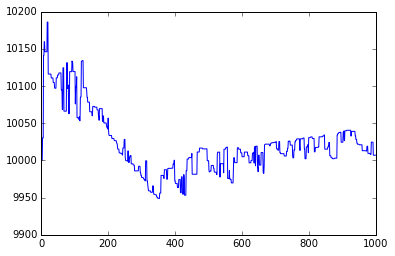

In [107]:
plt.plot(past_data)

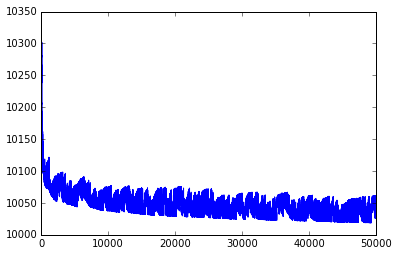

In [142]:
past_data = AM.one_market_simulation(50000)
plt.plot(past_data)

In [114]:
past_data2, T_A, T_B, share = AM.two_market_simulation(2)

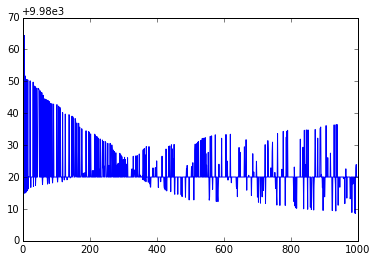

In [115]:
plt.plot(past_data2)

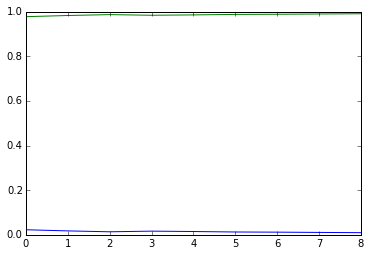

In [14]:
AM.plot_share(share)

In [31]:
past_data2[-1]

9986.367058720394